<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week5/RNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clothing Reviews Sentiment Analysis with RNN
# PyTorch Implementation

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.corpus import stopwords
import nltk
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Download stopwords if needed
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text
    return ""


In [ ]:
# Load the data

url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv'
data = pd.read_csv(url)

In [ ]:
data

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
# Clean the review text
data['clean_review'] = data['Review Text'].apply(clean_text)




In [ ]:
# Convert Rating to binary sentiment (1-3: Negative, 4-5: Positive)
data['sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 4 else 0)



In [ ]:
# Check class distribution
print("Class distribution:")
print(data['sentiment'].value_counts())

Class distribution:
sentiment
1    18208
0     5278
Name: count, dtype: int64


In [ ]:
# Create vocabulary
def create_vocabulary(texts, max_words=10000):
    word_counts = Counter()
    for text in texts:
        words = text.split()
        word_counts.update(words)

    # Sort words by frequency
    common_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:max_words]
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for i, (word, _) in enumerate(common_words):
        vocab[word] = i + 2
    return vocab

In [ ]:
# Create vocabulary from the cleaned reviews
vocab = create_vocabulary(data['clean_review'].values)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 10002


In [ ]:
# Convert text to sequences
def text_to_sequence(text, vocab, max_len=100):
    words = text.split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words[:max_len]]
    # Pad sequence
    if len(sequence) < max_len:
        sequence += [vocab['<PAD>']] * (max_len - len(sequence))
    return sequence

max_len = 100  # Maximum length of sequences
data['sequence'] = data['clean_review'].apply(lambda x: text_to_sequence(x, vocab, max_len))


In [ ]:
# Split the data
X = np.array(data['sequence'].tolist())
y = data['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 18788
Testing set size: 4698


In [ ]:
# Step 2: Create Dataset and DataLoader
class ReviewDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


In [ ]:
# Create datasets
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)


In [ ]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
# Step 3: Define the RNN Model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers):
        """
        Initialize the Sentiment RNN model

        Parameters:
        - vocab_size: size of the vocabulary
        - embed_size: dimension of word embeddings
        - hidden_size: number of features in hidden state
        - n_layers: number of stacked LSTM layers
        """
        super(SentimentRNN, self).__init__()

        # Embedding layer: Maps vocabulary indices to dense vectors of fixed size
        # embed_size is the dimension of these vectors
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # LSTM layer
        # hidden_size: number of features in the hidden state h
        # n_layers: number of recurrent layers (stacked LSTMs)
        self.lstm = nn.LSTM(embed_size, hidden_size, n_layers, batch_first=True, dropout=0.5)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, 1)

        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass through the network

        Parameters:
        - x: input sequence tensor of shape (batch_size, seq_length)

        Returns:
        - output: probability between 0-1 representing sentiment class
        """
        # Embed the input sequence
        # Shape after embedding: (batch_size, seq_length, embed_size)
        embedded = self.embedding(x)

        # Initialize hidden and cell states
        # Shape of hidden states: (n_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)

        # Forward propagate through LSTM
        # out shape: (batch_size, seq_length, hidden_size)
        # We take only the output from the last time step
        out, (hidden, cell) = self.lstm(embedded, (h0, c0))

        # Extract the last hidden state from the last layer
        # Shape: (batch_size, hidden_size)
        out = hidden[-1, :, :]

        # Apply dropout for regularization
        out = self.dropout(out)

        # Apply the fully connected layer
        # Shape: (batch_size, 1)
        out = self.fc(out)

        # Apply sigmoid activation to get probability
        out = self.sigmoid(out)

        return out.squeeze()


In [ ]:
# Hyperparameters
embed_size = 256
hidden_size = 128
n_layers = 4


In [ ]:
# Initialize the model
model = SentimentRNN(vocab_size, embed_size, hidden_size, n_layers).to(device)


In [ ]:
# Step 4: Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Step 5: Training the Model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

    return train_losses, train_accuracies


In [ ]:
# Step 6: Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()

    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()

            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    # Calculate AUC only if there are both positive and negative samples
    if len(set(all_labels)) > 1:
        auc = roc_auc_score(all_labels, all_probabilities)
    else:
        auc = float('nan')

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'labels': all_labels
    }


In [ ]:
# Train the model
print("Training the model...")
epochs = 10  # Increase if needed to reach 85% accuracy
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, epochs)


Training the model...
Epoch 1/10 | Loss: 0.5394 | Accuracy: 0.7735
Epoch 2/10 | Loss: 0.5359 | Accuracy: 0.7753
Epoch 3/10 | Loss: 0.5369 | Accuracy: 0.7753
Epoch 4/10 | Loss: 0.5348 | Accuracy: 0.7753
Epoch 5/10 | Loss: 0.5359 | Accuracy: 0.7753
Epoch 6/10 | Loss: 0.5351 | Accuracy: 0.7753
Epoch 7/10 | Loss: 0.5357 | Accuracy: 0.7753
Epoch 8/10 | Loss: 0.5349 | Accuracy: 0.7753
Epoch 9/10 | Loss: 0.5360 | Accuracy: 0.7753
Epoch 10/10 | Loss: 0.5351 | Accuracy: 0.7753


In [ ]:
# Evaluate on training set
print("Evaluating on training set...")
train_metrics = evaluate_model(model, train_loader)
print(f"Training Accuracy: {train_metrics['accuracy']:.4f}")
print(f"Training Precision: {train_metrics['precision']:.4f}")
print(f"Training Recall: {train_metrics['recall']:.4f}")
print(f"Training F1 Score: {train_metrics['f1']:.4f}")
print(f"Training AUC: {train_metrics['auc']:.4f}")


Evaluating on training set...
Training Accuracy: 0.7753
Training Precision: 0.7753
Training Recall: 1.0000
Training F1 Score: 0.8734
Training AUC: 0.5000


In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_metrics = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test F1 Score: {test_metrics['f1']:.4f}")
print(f"Test AUC: {test_metrics['auc']:.4f}")


Evaluating on test set...
Test Accuracy: 0.7752
Test Precision: 0.7752
Test Recall: 1.0000
Test F1 Score: 0.8734
Test AUC: 0.4999


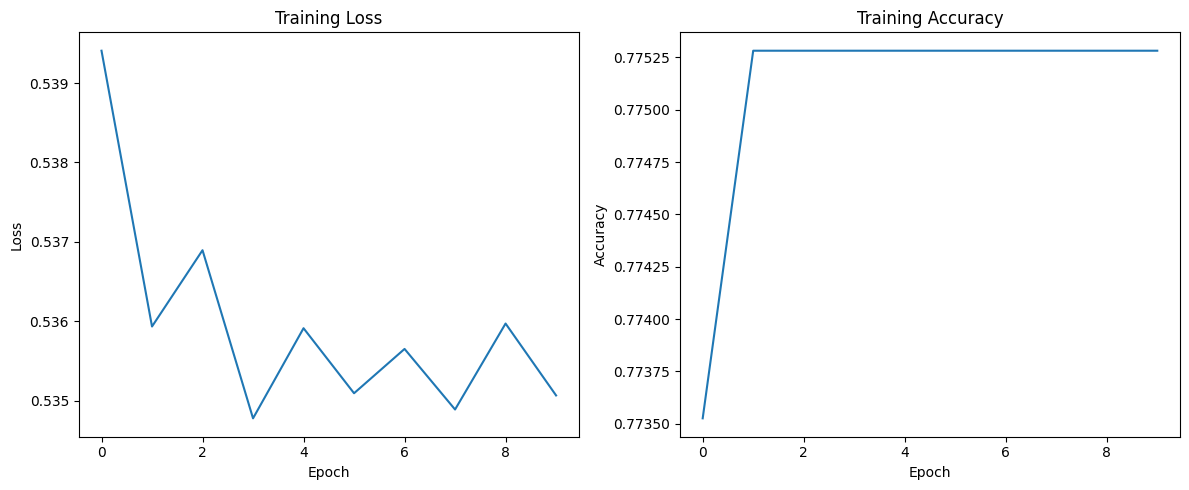

In [ ]:
# Step 7: Visualize Results
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

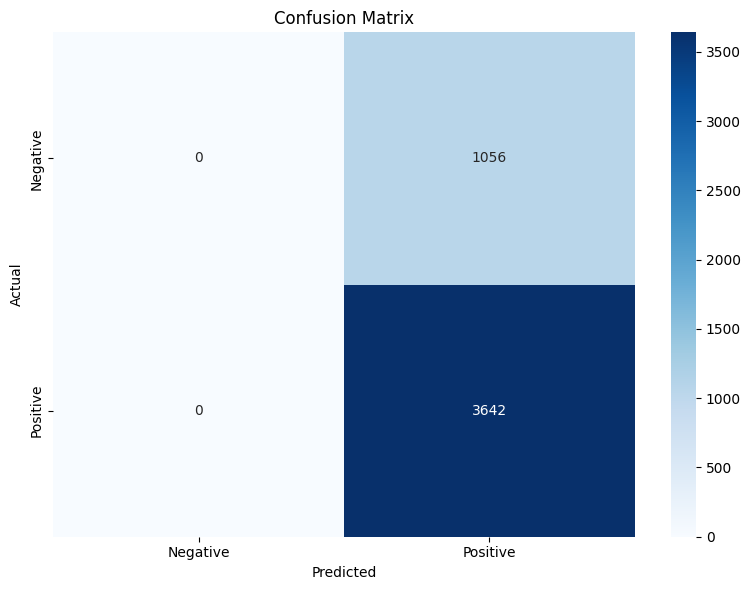

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'sentiment_rnn_model.pth')
print("Model saved as 'sentiment_rnn_model.pth'")


Model saved as 'sentiment_rnn_model.pth'


In [ ]:
# Function for predicting sentiment of new reviews
def predict_sentiment(model, review_text, vocab, max_len=100):
    model.eval()

    # Clean and preprocess the text
    cleaned_text = clean_text(review_text)
    sequence = text_to_sequence(cleaned_text, vocab, max_len)
    sequence_tensor = torch.tensor([sequence], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(sequence_tensor)
        prediction = "Positive" if output.item() >= 0.5 else "Negative"
        confidence = output.item() if output.item() >= 0.5 else 1 - output.item()

    return prediction, confidence

In [ ]:
# Example usage
example_review = "I absolutely love this dress! It fits perfectly and looks amazing."
prediction, confidence = predict_sentiment(model, example_review, vocab)
print(f"Example Review: '{example_review}'")
print(f"Prediction: {prediction} with {confidence:.4f} confidence")


Example Review: 'I absolutely love this dress! It fits perfectly and looks amazing.'
Prediction: Positive with 0.7827 confidence


# Summary of Mathematical Equations Used in the Model

## 1. Embedding Layer
- Transforms word indices into dense vectors of fixed size.
- If $E$ is the embedding matrix, and $x$ is a word index, then the embedding is $E[x]$.

## 2. LSTM Cell (Long Short-Term Memory)
- **Forget Gate**: $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$  
  The forget gate determines what information to discard from the cell state.  
  $\sigma$ is the sigmoid function that outputs values between 0 and 1.
  
- **Input Gate**: $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$  
  The input gate determines what new information to store in the cell state.
  
- **Cell State Candidate**: $\tilde{C}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c)$  
  This creates new candidate values that could be added to the cell state.
  
- **Update Cell State**: $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$  
  The new cell state combines the old state weighted by the forget gate
  and the new candidate values weighted by the input gate.
  
- **Output Gate**: $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$  
  The output gate determines what information from the cell state to output.
  
- **Hidden State**: $h_t = o_t * \tanh(C_t)$  
  The hidden state contains filtered information from the cell state.

## 3. Dropout
- During training, randomly sets a fraction $p$ of the input units to 0
- Formula: $y = d * x$ where $d$ is a binary mask sampled from $\text{Bernoulli}(1-p)$
- This prevents overfitting by making the network more robust

## 4. Fully Connected Layer
- Linear transformation: $y = Wx + b$
- $W$ is the weight matrix, $b$ is the bias term

## 5. Sigmoid Activation
- $\sigma(x) = \frac{1}{1 + e^{-x}}$
- Maps input to a value between 0 and 1, making it suitable for binary classification

## 6. Binary Cross Entropy Loss
- $\text{BCE}(y, \hat{y}) = -(y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}))$
- Measures the dissimilarity between the true labels $y$ and predicted probabilities $\hat{y}$

## 7. Adam Optimizer
- Adaptive learning rate optimization algorithm
- Combines ideas from momentum and RMSprop
- Updates parameters based on exponentially weighted moving averages of gradients
- Adapts learning rates for each parameter separately

## 8. Evaluation Metrics
- Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$
- Precision = $\frac{TP}{TP + FP}$
- Recall = $\frac{TP}{TP + FN}$
- F1 Score = $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$
- AUC: Area under the ROC curve

Where:
- TP = True Positives
- TN = True Negatives
- FP = False Positives
- FN = False Negatives